In [2]:
import scanpy as sc
import pickle as pkl
import pandas as pd
import numpy as np
# Make random number for seed before scvi import sets seed to 0
seed=np.random.randint(0,1000000)
import argparse
import os
import string
import subprocess

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import scgen
#import pytorch_lightning as pl

# Otherwise the seed remains constant
from scvi._settings import ScviConfig
config=ScviConfig()
config.seed=seed

/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed 

In [8]:
parser = argparse.ArgumentParser()
def intstr_to_bool(x):
    return bool(int(x))
def str_to_float_zeronone(x):
    if x is None or x=="0":
        return None
    else:
        return float(x)
parser.add_argument('-n', '--name', required=False, type=str, default=None,
                    help='name of replicate, if unspecified set to rSEED if seed is given '+\
                    'and else to blank string')
parser.add_argument('-s', '--seed', required=False, type=int, default=None,
                    help='random seed, if none it is randomly generated')
parser.add_argument('-po', '--params_opt', required=False, type=str, default='',
                    help='name of optimized params/test purpose')
parser.add_argument('-pa', '--path_adata', required=True, type=str,
                    help='full path to adata obj')
parser.add_argument('-ps', '--path_save', required=True, type=str,
                    help='directory path for saving, creates subdir within it')
parser.add_argument('-sk', '--system_key', required=True, type=str,
                    help='obs col with system info')
parser.add_argument('-gk', '--group_key', required=True, type=str,
                    help='obs col with group info')
parser.add_argument('-bk', '--batch_key', required=True, type=str,
                     help='obs col with batch info')
parser.add_argument('-ib', '--integrate_by', required=False, type=str,default='system',
                     help='use for integration batch, "system" or "batch"')
parser.add_argument('-me', '--max_epochs', required=False, type=int,default=50,
                    help='max_epochs for training')
parser.add_argument('-edp', '--epochs_detail_plot', required=False, type=int, default=20,
                    help='Loss subplot from this epoch on')
parser.add_argument('-kw', '--kl_weight', required=False, type=float, default=1.0,
                    help='max_kl_weight for trainingsplan')
parser.add_argument('-nce', '--n_cells_eval', required=False, type=int, default=-1,  
                    help='Max cells to be used for eval, if -1 use all cells. '+\
                   'For cell subsetting seed 0 is always used to be reproducible accros '+\
                   'runs with different seeds.')

parser.add_argument('-t', '--testing', required=False, type=intstr_to_bool,default='0',
                    help='Testing mode')

_StoreAction(option_strings=['-t', '--testing'], dest='testing', nargs=None, const=None, default='0', type=<function intstr_to_bool at 0x2acda1789f70>, choices=None, required=False, help='Testing mode', metavar=None)

In [9]:
if False:
    args= parser.parse_args(args=[
        '-pa','/om2/user/khrovati/data/cross_species_prediction/pancreas_healthy/combined_orthologuesHVG2000.h5ad',
        '-ps','/om2/user/khrovati/data/cross_system_integration/eval/test/integration/',
        '-sk','system',
        '-bk','sample',
        '-gk','cell_type',
        '-me','2',
        '-edp','0',
        
        '-s','1',
                
        '-nce','1000',
        
        '-t','1'
    ])
# Read command line args
else:
    args, args_unknown = parser.parse_known_args()
    
print(args)

TESTING=args.testing

if args.name is None:
    if args.seed is not None:
        args.name='r'+str(args.seed)

Namespace(name=None, seed=1, params_opt='', path_adata='/om2/user/khrovati/data/cross_species_prediction/pancreas_healthy/combined_orthologuesHVG2000.h5ad', path_save='/om2/user/khrovati/data/cross_system_integration/eval/test/integration/', system_key='system', group_key='cell_type', batch_key='sample', integrate_by='system', max_epochs=2, epochs_detail_plot=0, kl_weight=1.0, n_cells_eval=1000, testing=True)


In [25]:
# Make folder for saving
path_save=args.path_save+'scgen'+\
    '_'+''.join(np.random.permutation(list(string.ascii_letters)+list(string.digits))[:8])+\
    ('-TEST' if TESTING else '')+\
    os.sep

os.mkdir(path_save)
print("PATH_SAVE=",path_save)

PATH_SAVE= /om2/user/khrovati/data/cross_system_integration/eval/test/integration/scgen_tgbQ2lj4-TEST/


In [26]:
# Set seed for eval
# Set only here below as need randomness for generation of out directory name (above)
if args.seed is not None:
    config.seed=args.seed

[rank: 0] Global seed set to 1


In [27]:
# Save args
pkl.dump(args,open(path_save+'args.pkl','wb'))

## Integration

### Prepare data

In [28]:
# Load data
adata=sc.read(args.path_adata)

In [29]:
if TESTING:
    # Make data smaller if testing the script
    random_idx=np.random.permutation(adata.obs_names)[:5000]
    adata=adata[random_idx,:].copy()
    print(adata.shape)
    # Set some groups to nan for testing if this works
    adata.obs[args.group_key]=[np.nan]*10+list(adata.obs[args.group_key].iloc[10:])
    
    # Also remove nan from testing data - from real data this is not removed as it
    # would not match other integration scripts - will raise error
    adata=adata[~adata.obs[args.group_key].isna(),:].copy()

(5000, 1060)


### Training

In [30]:
print('Train')

Train


In [31]:
# Setup adata
adata_training = adata
if args.integrate_by=="system":
    integrate_by=args.system_key
elif args.integrate_by=="batch":
    integrate_by=args.batch_key
else:
    raise ValueError('integrate_by not recognised')
scgen.SCGEN.setup_anndata(adata_training, batch_key=integrate_by, labels_key=args.group_key)

/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [41]:
model = scgen.SCGEN(adata_training, kl_weight=args.kl_weight)

max_epochs=args.max_epochs if not TESTING else 3
model.train(
    max_epochs = max_epochs,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
)

/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/khrovati/miniconda/envs/perturb/lib/python ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/khrovati/miniconda/envs/perturb/lib/python ...
  rank_zero_warn(


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  2.10s/it, v_num=1, train_loss_step=72.1, train_loss_epoch=61.6]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it, v_num=1, train_loss_step=72.1, train_loss_epoch=61.6]


### Eval

#### Losses

In [33]:
print('Plot losses')

Plot losses


In [34]:
# Save losses
pkl.dump(model.trainer.logger.history,open(path_save+'losses.pkl','wb'))

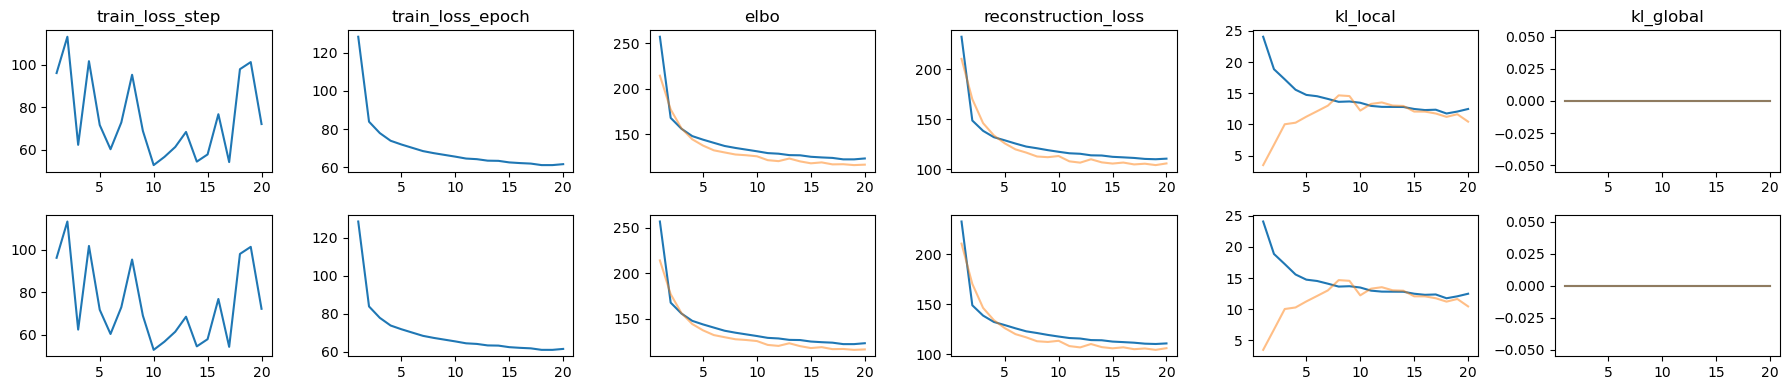

In [48]:
# Plot all loses
steps_detail_plot = args.epochs_detail_plot*int(
    model.trainer.logger.history['validation_loss'].shape[0]/max_epochs)
detail_plot= steps_detail_plot
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    if 'lr-' not in l_train and '_eval' not in l_train and 'train_' not in l_train:
        l_val=l_train.replace('_train','_validation')
        l_name=l_train.replace('_train','')
        # Change idx of epochs to start with 1 so that below adjustment when 
        # train on step which only works for wal leads to appropriate multiplication
        l_val_values=model.trainer.logger.history[l_val].copy()
        l_val_values.index=l_val_values.index+1
        l_train_values=model.trainer.logger.history[l_train].copy()
        l_train_values.index=l_train_values.index+1
        # This happens if log on step as currently tyhis works only for val loss
        if l_train_values.shape[0]<l_val_values.shape[0]:
            l_train_values.index=\
                l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
        for l_values,c,alpha,dp in [
            # train loss logged on epoch in either case now
            (l_train_values,'tab:blue',1,args.epochs_detail_plot),
            (l_val_values,'tab:orange',0.5, detail_plot)]:
            axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
            axs[0,ax_i].set_title(l_name)
            axs[1,ax_i].plot(l_values.index[dp:],
                             l_values.values.ravel()[dp:],c=c,alpha=alpha)
    else:
        l_values=model.trainer.logger.history[l_train].copy()
        l_values.index=l_values.index+1
        axs[0,ax_i].plot(l_values.index,l_values.values.ravel())
        axs[0,ax_i].set_title(l_train.replace('_validation_eval',''))
        # Lr has index of steps but logged number of epochs
        dp= args.epochs_detail_plot if 'lr-' in l_train else detail_plot
        axs[1,ax_i].plot(l_values.index[dp:],l_values.values.ravel()[dp:])
        if 'lr' in l_train:
            axs[0,ax_i].set_yscale('log')
            axs[1,ax_i].set_yscale('log')
fig.tight_layout()
plt.savefig(path_save+'losses.png',dpi=300,bbox_inches='tight')

#### Embedding

In [36]:
print('Get embedding')

Get embedding


In [16]:
# Compute and save whole embedding
if args.n_cells_eval!=-1:
    embed_full = model.batch_removal(adata_training).obsm['latent']
    embed_full=sc.AnnData(embed_full,obs=adata_training.obs)
    # Make system categorical for eval as below
    embed_full.obs[args.system_key]=embed_full.obs[args.system_key].astype(str)
    # Save full embed
    embed_full.write(path_save+'embed_full.h5ad')
    del embed_full

/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


In [43]:
# Compute embedding
cells_eval=adata_training.obs_names if args.n_cells_eval==-1 else \
    np.random.RandomState(seed=0).permutation(adata_training.obs_names)[:args.n_cells_eval]
print('N cells for eval:',cells_eval.shape[0])
embed = model.batch_removal(adata=adata_training[cells_eval,:]).obsm['latent']
embed=sc.AnnData(embed,obs=adata_training[cells_eval,:].obs)
# Make system categorical for metrics and plotting
embed.obs[args.system_key]=embed.obs[args.system_key].astype(str)
# Save embed
embed.write(path_save+'embed.h5ad')
del embed

N cells for eval: 1000
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/om2/user/khrovati/miniconda/envs/perturb/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en

In [18]:
del adata
del adata_training

# End

In [19]:
print('Finished integration!')

Finished integration!
